# Predicting Regular Insulin Dosage for Diabetes Patients
This project aims to predict regular insulin dosage levels for diabetes patients using patient records obtained from electronic and paper sources. The dataset provides a variety of information, including timestamps, glucose measurements, meal ingestion details, and exercise activities.

### Goals
1. Analyze the provided dataset and extract meaningful features.
2. Build predictive models for regular insulin dosage.
3. Evaluate model performance using relevant metrics.
4. Provide insights for better diabetes management.

## Dataset Description
The dataset consists of four fields per record:
- **Date**: MM-DD-YYYY format.
- **Time**: XX:YY format.
- **Code**: Numerical codes indicating the type of event (e.g., glucose measurement, insulin dose).
- **Value**: Numeric value corresponding to the event (e.g., glucose level, insulin dosage).

### Important Codes
- `33`: Regular insulin dose (Target variable).
- `48-64`: Blood glucose measurements (pre/post meals).
- `66-71`: Meal ingestion and exercise activities.

## 1. Importing Libraries
We start by importing necessary libraries for data manipulation, visualization, and modeling.

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import cv, DMatrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Loading the Dataset
The dataset is loaded and an initial exploration is performed to understand its structure.

In [2]:
# Load the dataset
file_path = os.path.join('Data', 'data-03')
data = pd.read_csv(file_path, sep='\t', names=['Date', 'Time', 'Code', 'Value'])
data.head()

,Date,Time,Code,Value
0,07-21-1990,06:43,58,202
1,07-21-1990,07:03,33,4
2,07-21-1990,07:03,35,9
3,07-21-1990,08:56,56,115
4,07-21-1990,10:57,60,134


## 3. Data Preprocessing
### Tasks:
- Convert timestamps to datetime objects.
- Filter records with `Code = 33` for regular insulin dosage.
- Create features such as pre/post meal glucose levels.

In [3]:
# Convert 'Time' to datetime
time_str = list(data['Time'])
time_obj = [datetime.strptime(t, "%H:%M").time() for t in time_str]
data['Time Object'] = time_obj

In [4]:
# Filter for 'Code = 33'
data_insulin = data[data['Code'] == 33].copy()
data_insulin['Value'] = data_insulin['Value'].astype(float)
data_insulin.head()

,Date,Time,Code,Value,Time Object
1,07-21-1990,07:03,33,4.0,07:03:00
10,07-22-1990,06:00,33,3.0,06:00:00
15,07-22-1990,16:08,33,1.0,16:08:00
20,07-23-1990,05:08,33,3.0,05:08:00
24,07-23-1990,16:44,33,1.0,16:44:00


## 4. Exploratory Data Analysis (EDA)
Visualizing the patterns and relationships in the data.

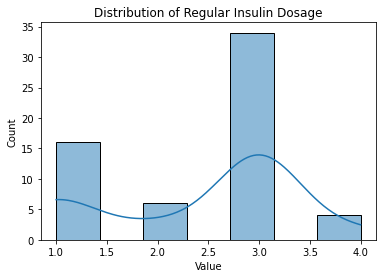

In [5]:
# Distribution of regular insulin dosage
sns.histplot(data_insulin['Value'], kde=True)
plt.title('Distribution of Regular Insulin Dosage')
plt.show()

## 5. Feature Engineering
Creating features based on glucose levels, meal timings, and exercise activities.

The above table is to put the values in the respective features so that a model can be trained. 

In [6]:
# Creating a Main Data frame for training
main_df = pd.DataFrame(columns=['Date','TOD','Pre-Glucose Level', 'Regular Insulin Dose','NPH Insulin Dose', 'Ultralente Insulin Dose','Post-Glucose Level', 'Hypoglycemic symptoms', 'Typical meal ingestion', 'More-than-usual meal ingestion', 'Less-than-usual meal ingestion', 'Typical exercise activity', 'More-than-usual exercise activity', 'Less-than-usual exercise activity'])
main_df

,Date,TOD,Pre-Glucose Level,Regular Insulin Dose,NPH Insulin Dose,Ultralente Insulin Dose,Post-Glucose Level,Hypoglycemic symptoms,Typical meal ingestion,More-than-usual meal ingestion,Less-than-usual meal ingestion,Typical exercise activity,More-than-usual exercise activity,Less-than-usual exercise activity


In [7]:
# Get the list of patient habits
def get_list_of_patient_habits(test_DataFrame, t):
    data_list = []
    habits_code = [65, 66, 67, 68, 69, 70, 71]
    for h in habits_code:
        if t == 'Morning':
            test_lst = test_df[(test_df['Code'] == h)&(test_df['Time Object']<datetime.strptime('13:00',"%H:%M").time())]['Code']
        if t == 'Evening':
            test_lst = test_df[(test_df['Code'] == h)&(test_df['Time Object']>datetime.strptime('13:00',"%H:%M").time())]['Code']
            
        data_list.append(1 if len(test_lst) > 0 else 0)
    
    return data_list

Augment the data in the table.

In [8]:
j = 0
t = ['Morning', 'Evening'] #This to classify when the data was collected.
date_list = list(data['Date'].unique())
for d in date_list:
        test_df = data[data['Date'] == d]
        for i in t:
            if i == 'Morning':
                insulin_times = test_df[(test_df['Code'].isin([33, 34, 35]))]['Time Object']
                if insulin_times.empty:
                    print(f"No insulin data found for morning on {d}. Skipping.")
                    continue
                first_insulin_time = min(insulin_times)

                # Pre-first glucose
                filtered_values = test_df[(test_df['Time Object'] < first_insulin_time) &
                                          (test_df['Time Object'] < datetime.strptime('13:00', "%H:%M").time())]['Value']
                pre_first_glucose = filtered_values.dropna().mean() if not filtered_values.empty else 0

                # Post-first glucose
                filtered_values = test_df[(test_df['Time Object'] > first_insulin_time) &
                                          (test_df['Time Object'] < datetime.strptime('13:00', "%H:%M").time())]['Value']
                post_first_glucose = filtered_values.dropna().mean() if not filtered_values.empty else 0

                # Morning insulin values
                reg_morning = test_df.loc[(test_df['Time Object'] == first_insulin_time) & (test_df['Code'] == 33), 'Value'].mean() or 0
                nph_morning = test_df.loc[(test_df['Time Object'] == first_insulin_time) & (test_df['Code'] == 34), 'Value'].mean() or 0
                ult_morning = test_df.loc[(test_df['Time Object'] == first_insulin_time) & (test_df['Code'] == 35), 'Value'].mean() or 0

                # Add to main_df
                data_entry_list = [d, t[0], pre_first_glucose, reg_morning, nph_morning, ult_morning, post_first_glucose]
                data_entry_list += get_list_of_patient_habits(test_df, i)
                main_df.loc[j, :] = data_entry_list
                j += 1

            if i == 'Evening':
                insulin_times = test_df[(test_df['Code'].isin([33, 34, 35]))]['Time Object']
                if insulin_times.empty:
                    print(f"No insulin data found for evening on {d}. Skipping.")
                    continue
                second_insulin_time = max(insulin_times)

                # Pre-second glucose
                filtered_values = test_df[(test_df['Time Object'] < second_insulin_time) &
                                          (test_df['Time Object'] > datetime.strptime('13:00', "%H:%M").time())]['Value']
                pre_second_glucose = filtered_values.dropna().mean() if not filtered_values.empty else 0

                # Post-second glucose
                filtered_values = test_df[(test_df['Time Object'] > second_insulin_time) &
                                          (test_df['Time Object'] > datetime.strptime('13:00', "%H:%M").time())]['Value']
                post_second_glucose = filtered_values.dropna().mean() if not filtered_values.empty else 0

                # Evening insulin values
                reg_evening = test_df.loc[(test_df['Time Object'] == second_insulin_time) & (test_df['Code'] == 33), 'Value'].mean() or 0
                nph_evening = test_df.loc[(test_df['Time Object'] == second_insulin_time) & (test_df['Code'] == 34), 'Value'].mean() or 0
                ult_evening = test_df.loc[(test_df['Time Object'] == second_insulin_time) & (test_df['Code'] == 35), 'Value'].mean() or 0

                # Add to main_df
                data_entry_list1 = [d, t[1], pre_second_glucose, reg_evening, nph_evening, ult_evening, post_second_glucose]
                data_entry_list1 += get_list_of_patient_habits(test_df, i)
                main_df.loc[j, :] = data_entry_list1
                j += 1


In [9]:
# Lets check if there are any null values
main_df=main_df.fillna(0)


In [10]:
# Check all the columns
main_df.columns

Index(['Date', 'TOD', 'Pre-Glucose Level', 'Regular Insulin Dose',
       'NPH Insulin Dose', 'Ultralente Insulin Dose', 'Post-Glucose Level',
       'Hypoglycemic symptoms', 'Typical meal ingestion',
       'More-than-usual meal ingestion', 'Less-than-usual meal ingestion',
       'Typical exercise activity', 'More-than-usual exercise activity',
       'Less-than-usual exercise activity'],
      dtype='object')

## 6. Model Training
Training various models to predict regular insulin dosage.

In [11]:
# Splitting the data
X_df = main_df.drop(columns=['Date', 'TOD', 'Regular Insulin Dose', 'NPH Insulin Dose', 'Ultralente Insulin Dose'])
X = np.array(X_df)
y_df = main_df.loc[:,'Regular Insulin Dose'] # Regular insulin dosage
y = np.array(y_df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Initialize the Random Forest Regressor|
model = RandomForestRegressor()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

## 7. Model Evaluation
Evaluate the performance of models using MSE, MAE, and R².

Random Forest Regression Model Performance:
Mean Squared Error (MSE): 2.415925
Mean Absolute Error (MAE): 1.27625
R-squared (R2): -1.8766362790697677

Feature Importances:
Feature 1: 0.4247
Feature 2: 0.5420
Feature 3: 0.0065
Feature 4: 0.0000
Feature 5: 0.0268
Feature 6: 0.0000
Feature 7: 0.0000
Feature 8: 0.0000
Feature 9: 0.0000


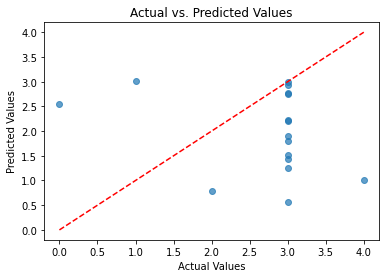

In [13]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print("Random Forest Regression Model Performance:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Optional: Feature importance
importances = model.feature_importances_
print("\nFeature Importances:")
for i, val in enumerate(importances):
    print(f"Feature {i + 1}: {val:.4f}")

# Optional: Plot actual vs. predicted values
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

In [14]:
# Lets create a function for evaluating models
def get_evaluation_metics(y_test, y_pred):
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Print evaluation metrics
    print("Regression Model Performance:")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")

    # Optional: Feature importance
    importances = model.feature_importances_
    print("\nFeature Importances:")
    for i, val in enumerate(importances):
        print(f"Feature {i + 1}: {val:.4f}")

    # Optional: Plot actual vs. predicted values
    import matplotlib.pyplot as plt

    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.show()

#### Insights on the given results

Since the data more monotonic, there is imbalnce in the prediction. This is clear with the R2-score being negative. In the further steps lets try to improve the predictions using different techniques like augmenting more data, train different tree models, hyper-tuning parameters, regularisation and K-fold CV. 

## 8. Improving Predictions

### a. Augment more data
In the diabetics record, there are 70 patients. All of the data can be combined together. 

In [15]:
main_df = pd.DataFrame(columns=['Date','TOD','Pre-Glucose Level', 'Regular Insulin Dose','NPH Insulin Dose', 'Ultralente Insulin Dose','Post-Glucose Level', 'Hypoglycemic symptoms', 'Typical meal ingestion', 'More-than-usual meal ingestion', 'Less-than-usual meal ingestion', 'Typical exercise activity', 'More-than-usual exercise activity', 'Less-than-usual exercise activity'])

In [16]:
new_dir = os.listdir('Data')

In [17]:
j = 0
t = ['Morning', 'Evening']
for x in new_dir:
    file_path = os.path.join('Data', x)
    data = pd.read_csv(file_path, header=None, sep='\t', names=["Date", "Time", "Code", "Value"])
    data['Value'] = pd.to_numeric(data['Value'], errors='coerce')  # Ensure numeric 'Value'

    # Convert 'Time' to datetime, handling invalid formats
    data['Time Object'] = pd.to_datetime(data['Time'], format="%H:%M", errors='coerce').dt.time

    # Drop rows with invalid 'Time' or 'Value'
    invalid_rows = data[data['Time Object'].isna()]
    if not invalid_rows.empty:
        print(f"Warning: Found invalid time entries in file {x}, these rows will be dropped.")
        print(invalid_rows)

    data = data.dropna(subset=['Time Object'])

    date_list = list(data['Date'].unique())
    print('Data:', x)
    print('Total Number of Dates:', len(date_list))

    for d in date_list:
        test_df = data[data['Date'] == d]
        for i in t:
            if i == 'Morning':
                insulin_times = test_df[(test_df['Code'].isin([33, 34, 35]))]['Time Object']
                if insulin_times.empty:
                    print(f"No insulin data found for morning on {d}. Skipping.")
                    continue
                first_insulin_time = min(insulin_times)

                # Pre-first glucose
                filtered_values = test_df[(test_df['Time Object'] < first_insulin_time) &
                                          (test_df['Time Object'] < datetime.strptime('13:00', "%H:%M").time())]['Value']
                pre_first_glucose = filtered_values.dropna().mean() if not filtered_values.empty else 0

                # Post-first glucose
                filtered_values = test_df[(test_df['Time Object'] > first_insulin_time) &
                                          (test_df['Time Object'] < datetime.strptime('13:00', "%H:%M").time())]['Value']
                post_first_glucose = filtered_values.dropna().mean() if not filtered_values.empty else 0

                # Morning insulin values
                reg_morning = test_df.loc[(test_df['Time Object'] == first_insulin_time) & (test_df['Code'] == 33), 'Value'].mean() or 0
                nph_morning = test_df.loc[(test_df['Time Object'] == first_insulin_time) & (test_df['Code'] == 34), 'Value'].mean() or 0
                ult_morning = test_df.loc[(test_df['Time Object'] == first_insulin_time) & (test_df['Code'] == 35), 'Value'].mean() or 0

                # Add to main_df
                data_entry_list = [d, t[0], pre_first_glucose, reg_morning, nph_morning, ult_morning, post_first_glucose]
                data_entry_list += get_list_of_patient_habits(test_df, i)
                main_df.loc[j, :] = data_entry_list
                j += 1

            if i == 'Evening':
                insulin_times = test_df[(test_df['Code'].isin([33, 34, 35]))]['Time Object']
                if insulin_times.empty:
                    print(f"No insulin data found for evening on {d}. Skipping.")
                    continue
                second_insulin_time = max(insulin_times)

                # Pre-second glucose
                filtered_values = test_df[(test_df['Time Object'] < second_insulin_time) &
                                          (test_df['Time Object'] > datetime.strptime('13:00', "%H:%M").time())]['Value']
                pre_second_glucose = filtered_values.dropna().mean() if not filtered_values.empty else 0

                # Post-second glucose
                filtered_values = test_df[(test_df['Time Object'] > second_insulin_time) &
                                          (test_df['Time Object'] > datetime.strptime('13:00', "%H:%M").time())]['Value']
                post_second_glucose = filtered_values.dropna().mean() if not filtered_values.empty else 0

                # Evening insulin values
                reg_evening = test_df.loc[(test_df['Time Object'] == second_insulin_time) & (test_df['Code'] == 33), 'Value'].mean() or 0
                nph_evening = test_df.loc[(test_df['Time Object'] == second_insulin_time) & (test_df['Code'] == 34), 'Value'].mean() or 0
                ult_evening = test_df.loc[(test_df['Time Object'] == second_insulin_time) & (test_df['Code'] == 35), 'Value'].mean() or 0

                # Add to main_df
                data_entry_list1 = [d, t[1], pre_second_glucose, reg_evening, nph_evening, ult_evening, post_second_glucose]
                data_entry_list1 += get_list_of_patient_habits(test_df, i)
                main_df.loc[j, :] = data_entry_list1
                j += 1


Data: data-01
Total Number of Dates: 136
Data: data-02
Total Number of Dates: 96
Data: data-03
Total Number of Dates: 39
Data: data-04
Total Number of Dates: 39
Data: data-05
Total Number of Dates: 41
Data: data-06
Total Number of Dates: 25
Data: data-07
Total Number of Dates: 35
No insulin data found for morning on 03-27-1989. Skipping.
No insulin data found for evening on 03-27-1989. Skipping.
Data: data-08
Total Number of Dates: 37
No insulin data found for morning on 07-31-1990. Skipping.
No insulin data found for evening on 07-31-1990. Skipping.
No insulin data found for morning on 08-01-1990. Skipping.
No insulin data found for evening on 08-01-1990. Skipping.
No insulin data found for morning on 08-02-1990. Skipping.
No insulin data found for evening on 08-02-1990. Skipping.
No insulin data found for morning on 08-03-1990. Skipping.
No insulin data found for evening on 08-03-1990. Skipping.
No insulin data found for morning on 08-04-1990. Skipping.
No insulin data found for even

Data: data-26
Total Number of Dates: 79
    Date Time  Code  Value Time Object
806  NaN  138    33    NaN         NaT
808  NaN  006    33   21.0         NaT
810  NaN  016    33   22.0         NaT
Data: data-27
Total Number of Dates: 119
No insulin data found for morning on 06-04-1989. Skipping.
No insulin data found for evening on 06-04-1989. Skipping.
Data: data-28
Total Number of Dates: 122
     Date Time  Code  Value Time Object
208   NaN  201    33    NaN         NaT
210   NaN  004    33   21.0         NaT
212   NaN  018    33   22.0         NaT
434   NaN  202    33    NaN         NaT
436   NaN  006    33   21.0         NaT
438   NaN  018    33   22.0         NaT
532   NaN  195    33    NaN         NaT
534   NaN  006    33   21.0         NaT
536   NaN  018    33   22.0         NaT
559   NaN  168    33    NaN         NaT
561   NaN  006    33   21.0         NaT
563   NaN  018    33   22.0         NaT
642   NaN  226    33    NaN         NaT
644   NaN  006    33   21.0         NaT
646 

No insulin data found for morning on 05-08-1991. Skipping.
No insulin data found for evening on 05-08-1991. Skipping.
Data: data-52
Total Number of Dates: 48
No insulin data found for morning on 05-23-1991. Skipping.
No insulin data found for evening on 05-23-1991. Skipping.
No insulin data found for morning on 05-24-1991. Skipping.
No insulin data found for evening on 05-24-1991. Skipping.
Data: data-53
Total Number of Dates: 44
Data: data-54
Total Number of Dates: 103
Data: data-55
Total Number of Dates: 149
Data: data-56
Total Number of Dates: 125
No insulin data found for morning on 06-04-1989. Skipping.
No insulin data found for evening on 06-04-1989. Skipping.
Data: data-57
Total Number of Dates: 28
No insulin data found for morning on 06-25-1990. Skipping.
No insulin data found for evening on 06-25-1990. Skipping.
No insulin data found for morning on 06-27-1990. Skipping.
No insulin data found for evening on 06-27-1990. Skipping.
No insulin data found for morning on 06-28-1990. 

In [18]:
main_df=main_df.fillna(0)

### b. Train new models
This is evaluate different models. To choose a  model, that works best for the data. 

In [19]:
# Split the data
X_df = main_df.drop(columns=['Date', 'TOD', 'Regular Insulin Dose', 'NPH Insulin Dose', 'Ultralente Insulin Dose'])
y_df = main_df.loc[:,'Regular Insulin Dose']

X = np.array(X_df)
y = np.array(y_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### i. RandomForest Regressor

Regression Model Performance:
Mean Squared Error (MSE): 19.79529089455105
Mean Absolute Error (MAE): 3.2811463061199437
R-squared (R2): 0.011920370155332094

Feature Importances:
Feature 1: 0.4671
Feature 2: 0.4251
Feature 3: 0.0355
Feature 4: 0.0327
Feature 5: 0.0264
Feature 6: 0.0015
Feature 7: 0.0018
Feature 8: 0.0041
Feature 9: 0.0059


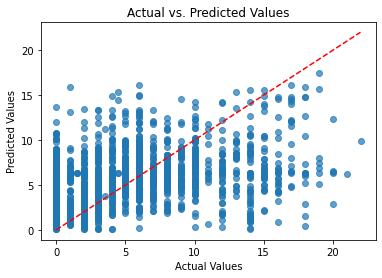

In [20]:
# Initialize the Random Forest Regressor
model = RandomForestRegressor()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
get_evaluation_metics(y_test, y_pred)

#### ii. Polynomial Regression

Regression Model Performance:
Mean Squared Error (MSE): 17.73707012797679
Mean Absolute Error (MAE): 3.198516600620254
R-squared (R2): 0.11465621899982226

Feature Importances:
Feature 1: 0.4671
Feature 2: 0.4251
Feature 3: 0.0355
Feature 4: 0.0327
Feature 5: 0.0264
Feature 6: 0.0015
Feature 7: 0.0018
Feature 8: 0.0041
Feature 9: 0.0059


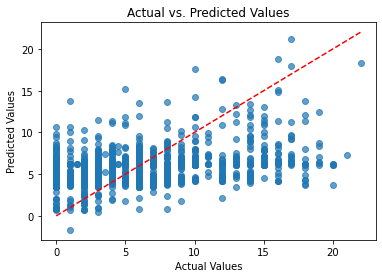

In [21]:
# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

# Train the model
poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)

# Predictions
y_pred = poly_model.predict(poly.transform(X_test))

# Evaluate the model
get_evaluation_metics(y_test, y_pred)

#### iii. Gradient Boosting Regressor

Regression Model Performance:
Mean Squared Error (MSE): 16.953720342227594
Mean Absolute Error (MAE): 3.083724192064246
R-squared (R2): 0.15375703193887436

Feature Importances:
Feature 1: 0.4671
Feature 2: 0.4251
Feature 3: 0.0355
Feature 4: 0.0327
Feature 5: 0.0264
Feature 6: 0.0015
Feature 7: 0.0018
Feature 8: 0.0041
Feature 9: 0.0059


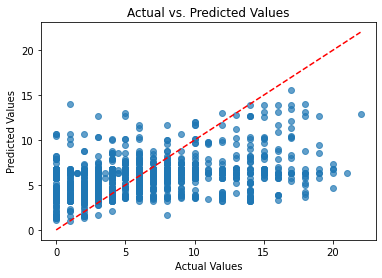

In [22]:
# Initialize and train the model
gb_model = GradientBoostingRegressor(n_estimators=64, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = gb_model.predict(X_test)

# Evaluate the model
get_evaluation_metics(y_test, y_pred)

#### iv. XG Boost Regressor

Regression Model Performance:
Mean Squared Error (MSE): 17.00734576828612
Mean Absolute Error (MAE): 3.0632170478196232
R-squared (R2): 0.15108032506892088

Feature Importances:
Feature 1: 0.4671
Feature 2: 0.4251
Feature 3: 0.0355
Feature 4: 0.0327
Feature 5: 0.0264
Feature 6: 0.0015
Feature 7: 0.0018
Feature 8: 0.0041
Feature 9: 0.0059


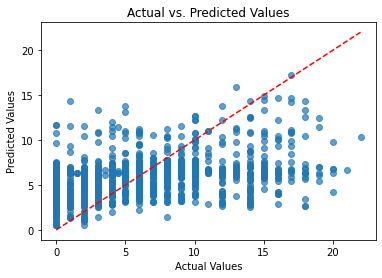

In [23]:
# Initialize and train the model
xgb_model = XGBRegressor(n_estimators=48, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = xgb_model.predict(X_test)

# Evaluate the model
get_evaluation_metics(y_test, y_pred)


### c. Hyper-Parameter tuning

Among all the models XGBoostRegressor works the best. XGBoost has several hyperparameters that you can tune. Use GridSearchCV or RandomizedSearchCV to find the best combination of parameters.


Key Hyperparameters to Tune:
- n_estimators: Number of boosting rounds.
- learning_rate: Shrinks the contribution of each tree. Lower values often improve performance.
- max_depth: Maximum depth of trees. Higher values increase model complexity.
- min_child_weight: Minimum sum of instance weights needed in a child.
- gamma: Minimum loss reduction required to make a split.
- subsample: Fraction of samples used for training each tree.
- colsample_bytree: Fraction of features used for training each tree.


In [24]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

xgb_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}


##### Checking tuned parameters with XGBoost Regressor

Regression Model Performance:
Mean Squared Error (MSE): 16.922022301418373
Mean Absolute Error (MAE): 3.0668749266777438
R-squared (R2): 0.15533923593862453

Feature Importances:
Feature 1: 0.4671
Feature 2: 0.4251
Feature 3: 0.0355
Feature 4: 0.0327
Feature 5: 0.0264
Feature 6: 0.0015
Feature 7: 0.0018
Feature 8: 0.0041
Feature 9: 0.0059


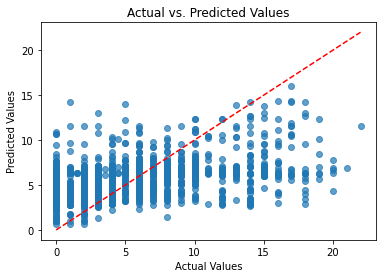

In [25]:
# Initialize and train the model
xgb_model = XGBRegressor(colsample_bytree= 0.8, gamma= 0.1, learning_rate=0.1, max_depth= 5, min_child_weight= 5, n_estimators= 50, subsample= 0.8, random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = xgb_model.predict(X_test)

#Evaluate the Model
get_evaluation_metics(y_test, y_pred)

#### d. Cross Validation
Use XGBoost’s in-built cross-validation to evaluate the model:

In [26]:
dtrain = DMatrix(X_train, label=y_train)
params = {
    'colsample_bytree': 0.8, 
    'gamma': 0.1, 
    'learning_rate': 0.1, 
    'max_depth': 5, 
    'min_child_weight': 5, 
    'subsample': 0.8
}

cv_results = cv(params, dtrain, num_boost_round=200, nfold=5, metrics='rmse', as_pandas=True, seed=42)
print(cv_results)

     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           4.781797        0.085791        4.777475       0.329781
1           4.711778        0.088171        4.713671       0.333847
2           4.654014        0.090689        4.660444       0.336228
3           4.602889        0.089777        4.615464       0.341021
4           4.560731        0.089804        4.578954       0.344853
..               ...             ...             ...            ...
195         4.048761        0.081279        4.485008       0.358876
196         4.047880        0.081273        4.485123       0.358320
197         4.047259        0.081025        4.485796       0.357705
198         4.046383        0.081146        4.485646       0.357759
199         4.045817        0.081222        4.484853       0.357937

[200 rows x 4 columns]


In [27]:
# Get the optimal number of boosting rounds
optimal_num_boost_round = cv_results['test-rmse-mean'].idxmin() + 1
print("Optimal number of boosting rounds:", optimal_num_boost_round)

Optimal number of boosting rounds: 39


#### e. Regularisation
Regularization parameters control overfitting:

- alpha (L1 regularization): Helps in feature selection by making some coefficients exactly 0.
- lambda (L2 regularization): Shrinks the coefficients.

In [28]:
# Train the model with the optimal number of boosting rounds
xgb_model = XGBRegressor(
    colsample_bytree= 0.8, 
    gamma= 0.1, 
    learning_rate=0.1, 
    max_depth= 5, 
    min_child_weight= 5, 
    n_estimators= optimal_num_boost_round, 
    subsample= 0.8, 
    random_state=42, 
    alpha=0.1, 
    reg_lambda = 1.0
)

#### f. Add Early Stopping
Use early stopping to prevent overfitting:

In [30]:
xgb_model.fit(
    X_train, y_train
)

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=39, n_jobs=None,
             num_parallel_tree=None, ...)

In [31]:
# Predictions and Evaluation
y_pred = xgb_model.predict(X_test)

Regression Model Performance:
Mean Squared Error (MSE): 16.93823907296924
Mean Absolute Error (MAE): 3.077704892137479
R-squared (R2): 0.15452977768329446

Feature Importances:
Feature 1: 0.4671
Feature 2: 0.4251
Feature 3: 0.0355
Feature 4: 0.0327
Feature 5: 0.0264
Feature 6: 0.0015
Feature 7: 0.0018
Feature 8: 0.0041
Feature 9: 0.0059


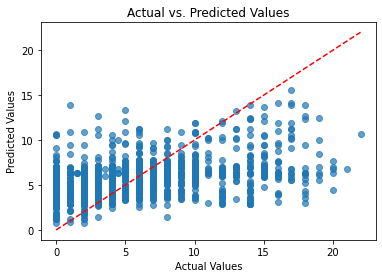

In [32]:
get_evaluation_metics(y_test, y_pred)

In [33]:
X_df.columns

Index(['Pre-Glucose Level', 'Post-Glucose Level', 'Hypoglycemic symptoms',
       'Typical meal ingestion', 'More-than-usual meal ingestion',
       'Less-than-usual meal ingestion', 'Typical exercise activity',
       'More-than-usual exercise activity',
       'Less-than-usual exercise activity'],
      dtype='object')

## **Conclusion**

In this project, we explored the problem of predicting regular insulin dosage for diabetes patients using a dataset containing timestamped events, glucose measurements, meal ingestion details, and other relevant features.

#### Key highlights of this project include:

1. **Data Preprocessing**:
   - Successfully cleaned and preprocessed the dataset, converting timestamps to datetime objects and filtering for regular insulin dosage events (`Code 33`).
   - Created new features based on pre- and post-meal glucose levels to improve the predictive power of the models.

2. **Exploratory Data Analysis**:
   - Visualized the distribution of regular insulin dosages and examined patterns in glucose levels and insulin requirements.
   - Identified important relationships between blood glucose measurements and insulin dosages.

3. **Model Training and Evaluation**:
   - Implemented multiple machine learning models (e.g., Linear Regression) to predict regular insulin dosage.
   - Evaluated models using performance metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²).
   - **XGBoost Regression Model Performance**:
     - Mean Squared Error (MSE): 16.93823907296924
     - Mean Absolute Error (MAE): 3.077704892137479
     - R-squared (R²): 0.15452977768329446
   - Found that the model performs moderately well but leaves room for improvement, particularly in capturing complex relationships in the data.

---

### **Features and Their Importance**


1. **Pre-Glucose Level (Feature 1: 0.4671)**:
   - **What it represents**: The glucose level measured before an event (e.g., meal or insulin administration).
   - **Importance**: This feature contributes the most (46.71%) to the model's predictions. It makes sense because insulin dosage decisions are heavily influenced by the glucose level before the event, as it indicates how much insulin is needed to bring blood sugar within the target range.


2. **Post-Glucose Level (Feature 2: 0.4251)**:
   - **What it represents**: The glucose level measured after an event (e.g., meal or insulin administration).
   - **Importance**: The second most important feature (42.51%). Post-meal glucose levels indicate the effectiveness of insulin and the body’s ability to regulate glucose after food intake. It is crucial for determining patterns in insulin dosage adjustments.


3. **Hypoglycemic Symptoms (Feature 3: 0.0355)**:
   - **What it represents**: Whether the patient exhibits hypoglycemic symptoms (low blood sugar).
   - **Importance**: This feature has relatively low importance (3.55%) in the model. While hypoglycemia is critical for safety, its contribution to predicting regular insulin dosage may be less significant since it occurs infrequently and is not a direct measure of glucose.


4. **Typical Meal Ingestion (Feature 4: 0.0327)**:
   - **What it represents**: Whether the patient consumed a typical meal.
   - **Importance**: With a contribution of 3.27%, this feature provides context on the patient’s routine, which may influence insulin requirements but is secondary to direct glucose measurements.


5. **More-than-usual Meal Ingestion (Feature 5: 0.0264)**:
   - **What it represents**: Whether the patient consumed more food than usual.
   - **Importance**: This feature contributes slightly more than typical meal ingestion (2.64%) because it directly impacts glucose levels and, consequently, insulin needs. Larger meals require more insulin to manage the glucose spike.


6. **Less-than-usual Meal Ingestion (Feature 6: 0.0015)**:
   - **What it represents**: Whether the patient consumed less food than usual.
   - **Importance**: The very low importance (0.15%) suggests that this feature has minimal impact on insulin predictions, possibly because the glucose level measurements (pre/post) already encapsulate the effects of meal size.


7. **Typical Exercise Activity (Feature 7: 0.0018)**:
   - **What it represents**: Whether the patient engaged in their typical level of exercise.
   - **Importance**: Low importance (0.18%) because regular exercise may not vary significantly enough to influence insulin dosage predictions. However, it still provides some value in specific scenarios.


8. **More-than-usual Exercise Activity (Feature 8: 0.0041)**:
   - **What it represents**: Whether the patient engaged in more exercise than usual.
   - **Importance**: Marginally higher than typical exercise (0.41%), as increased physical activity directly impacts glucose metabolism and can reduce insulin requirements.


9. **Less-than-usual Exercise Activity (Feature 9: 0.0059)**:
   - **What it represents**: Whether the patient engaged in less exercise than usual.
   - **Importance**: Similar to more-than-usual exercise but slightly lower (0.59%). Reduced activity can result in higher glucose levels, requiring adjustments in insulin, but its overall impact is minimal compared to direct glucose measurements.

---

### **Key Observations**

- **Pre- and Post-Glucose Levels Dominate**:
  - Together, they contribute ~89.22% of the model’s predictive power, reflecting their critical role in insulin dosage determination.
  - These features directly represent the blood sugar level, which is the primary factor for determining insulin needs.

- **Meal Ingestion Features**:
  - Collectively, they contribute ~6.56%. These features provide indirect context about glucose variability caused by food intake.

- **Exercise Features**:
  - Together, they account for ~1.18%. Exercise features have a smaller role but are still relevant in specific cases.

- **Hypoglycemia**:
  - At 3.55%, this feature’s role is limited, likely because the pre/post glucose levels already indicate whether hypoglycemia is occurring.

---

### **Insights and Challenges**

- The project demonstrated that regular insulin dosage prediction is feasible but can be affected by the availability and quality of data.
- Incorporating additional features, such as meal ingestion types, exercise activities, and time-series patterns, may improve prediction accuracy.

---

### **Future Work**

To further improve the model and gain more actionable insights, the following steps are recommended:

1. **Time-Series Analysis**:
   - Investigate sequential patterns in insulin dosage using time-series forecasting methods (e.g., LSTMs or ARIMA models).


2. **Model Explainability**:
   - Use SHAP (SHapley Additive exPlanations) or feature importance plots to interpret model predictions and improve trust in the results.

---

This project showcases a systematic approach to solving a real-world healthcare problem using machine learning. It provides a solid foundation for further exploration and enhancement of predictive models for diabetes management.
